In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
images = []
lesions = []
from skimage.io import imread
import torch
from skimage.transform import resize
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import gc
import os

rcParams['figure.figsize'] = (15,4)
root = '/content/drive/MyDrive/dat'

for root, dirs, files in os.walk(os.path.join(root, './')):
    if root.endswith('X') or root.endswith('X1') or root.endswith('X2') or root.endswith('X3') or root.endswith('X4'):
        files = sorted(files)
        for i in range(len(files)):
            images.append(imread(os.path.join(root, files[i])))
    if root.endswith('y') or root.endswith('y1') or root.endswith('y2') or root.endswith('y3') or root.endswith('y4'):
        files = sorted(files)
        for i in range(len(files)):
          if (files[i] in ["133.png", "138.png", "174.png", "175.png", "177.png"]):
                continue
          lesions.append(imread(os.path.join(root, files[i])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [3]:
size = (256, 256)
X = np.array([resize(x, size, mode='constant', anti_aliasing=True,) for x in images], np.float32)
Y = np.array([resize(y, size, mode='constant', anti_aliasing=False).sum(axis=2) <= 1 for y in lesions], np.float32)

In [4]:
print(X.shape)
print(Y.shape)

(320, 256, 256, 4)
(320, 256, 256)


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

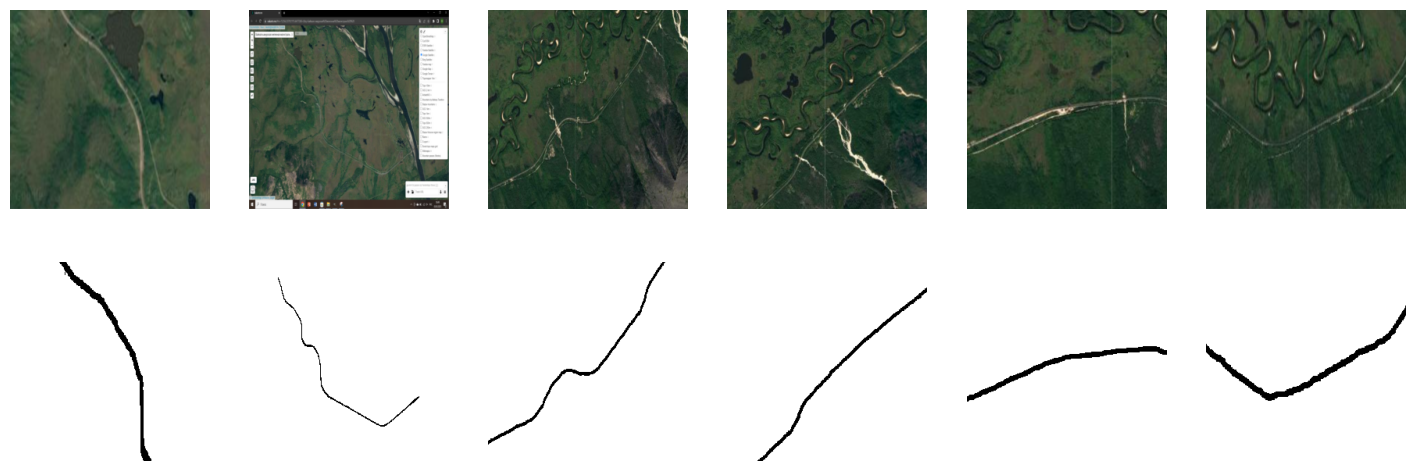

In [5]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap="gray")
plt.show();

Разделим наши картинки на train и validation выборки(3:1)

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [int(len(X)*0.75)])

#### PyTorch DataLoader

In [7]:
batch_size = 64
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
    axes[0].plot(history['epoch'], history['val_loss'], label='val_loss')
    axes[1].plot(history['epoch'], history['val_score'], label='val_score')
    for i in [0,1]: axes[i].legend()

In [10]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool4 =  nn.MaxPool2d(kernel_size=2, return_indices=True)
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1),
            # nn.BatchNorm2d(16),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1),
            # nn.BatchNorm2d(8),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=8, out_channels=4, kernel_size=1),
            # nn.BatchNorm2d(4),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=4, out_channels=2, kernel_size=1),
            # nn.BatchNorm2d(2),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1),
            # nn.BatchNorm2d(1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=1, out_channels=2, kernel_size=1),
            # nn.BatchNorm2d(2),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=2, out_channels=4, kernel_size=1),
            # nn.BatchNorm2d(4),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=1),
            # nn.BatchNorm2d(8),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1),
            # nn.BatchNorm2d(16),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            )
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            )
    def forward(self, x):
        # encoder
        e0, indices_e0 = self.pool0(self.enc_conv0(x))
        e1, indices_e1 = self.pool1(self.enc_conv1(e0))
        e2, indices_e2 = self.pool2(self.enc_conv2(e1))
        e3, indices_e3 = self.pool3(self.enc_conv3(e2))
        e4, indices_e4 = self.pool4(self.enc_conv4(e3))
        # bottleneck
        b = self.bottleneck_conv(e4)
        # decoder
        d0 = self.dec_conv0(self.upsample0(e4, indices_e4))
        d1 = self.dec_conv1(self.upsample1(d0, indices_e3))
        d2 = self.dec_conv2(self.upsample2(d1, indices_e2))
        d3 = self.dec_conv3(self.upsample3(d2, indices_e1))
        d4 = self.dec_conv4(self.upsample4(d3, indices_e0))  # no activation
        return d4

In [11]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.to(device).squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.to(device).squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

In [12]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, epsilon=0.5):
    history = {'epoch':[],'train_loss':[],'val_loss':[],'val_score':[]}
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights
  
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)
        
        

        # show intermediate results
        model.eval()
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        Y_hat = (torch.sigmoid(Y_hat) > epsilon).int()
#         Y_hat = torch.sigmoid(Y_hat)
        val_score = iou_pytorch(Y_val, Y_hat).mean()
        val_loss = loss_fn(Y_val, Y_hat)

        history['epoch'].append(epoch)
        history['train_loss'].append(avg_loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_score'].append(val_score.item())
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    plot_history(history)

In [14]:
def print_image(model, data_val, epsilon=0.6):
    X_val, Y_val = next(iter(data_val))
    model.eval()
    Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
    Y_hat = (torch.sigmoid(Y_hat) > epsilon).int()
    for k in range(6):
        plt.subplot(2, 6, k+1)
#         plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.imshow(Y_val[k,0].numpy(), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        res = X_val[k]
        res = np.rollaxis(X_val[k].numpy(), 0, 3).copy()
        for i in range(len(Y_hat[k,0])):
            for j in range(len(Y_hat[k,0][i])):
                  if (Y_hat[k,0][i][j].numpy() == 0):
                      res[i][j] = np.array([1., 1., 1. , 1.])
        plt.imshow(res, cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

In [15]:
def save_image(model, data_val, epsilon=0.6):
    for dat in data_val:
        X_val, Y_val = dat
        model.eval()
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        Y_hat = (torch.sigmoid(Y_hat) > epsilon).int()
        for k in range(len(Y_hat)):
            res = np.rollaxis(X_val[k].numpy(), 0, 3).copy()
            for i in range(len(Y_hat[k,0])):
                for j in range(len(Y_hat[k,0][i])):
                      if (Y_hat[k,0][i][j].numpy() == 0):
                          res[i][j] = np.array([1., 1., 1. , 1.])
            plt.imsave(f'test{k}.png', res, cmap="gray")

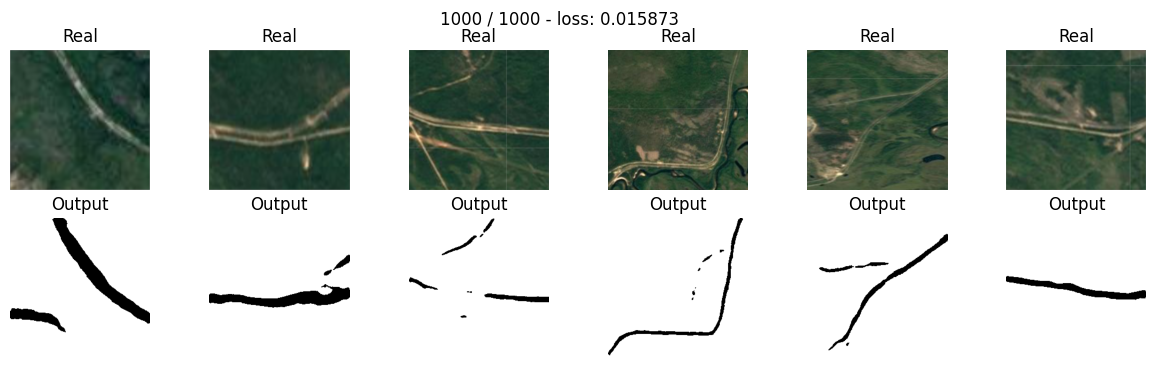

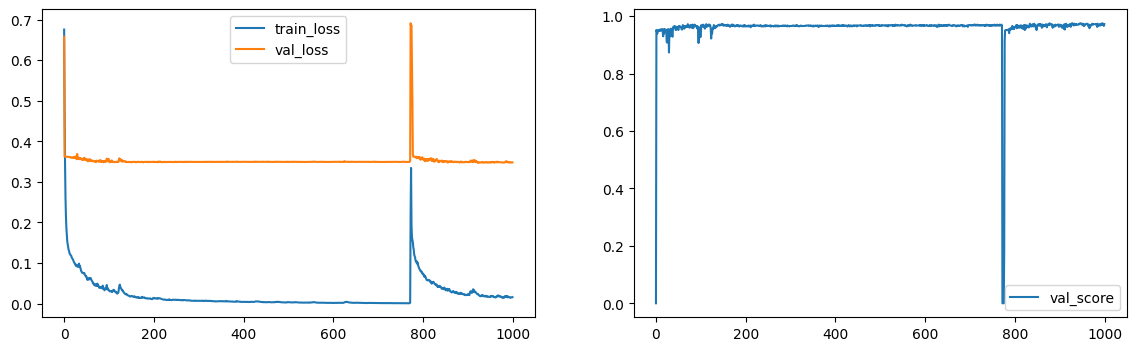

In [16]:
model = SegNet().to(device)
max_epochs = 1000
optim = torch.optim.Adam(model.parameters()) 
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [17]:
import pickle
# pickle.dump(model, '/content/drive/MyDrive/dat/model.pkl')
with open('/content/drive/MyDrive/dat/model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [ ]:
save_image(model, data_val)

In [18]:
torch.save(model, '/content/drive/MyDrive/dat/model.pth')

In [ ]:
model2 = torch.load('/content/drive/MyDrive/dat/model.pth')
model2.eval()

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0): Con

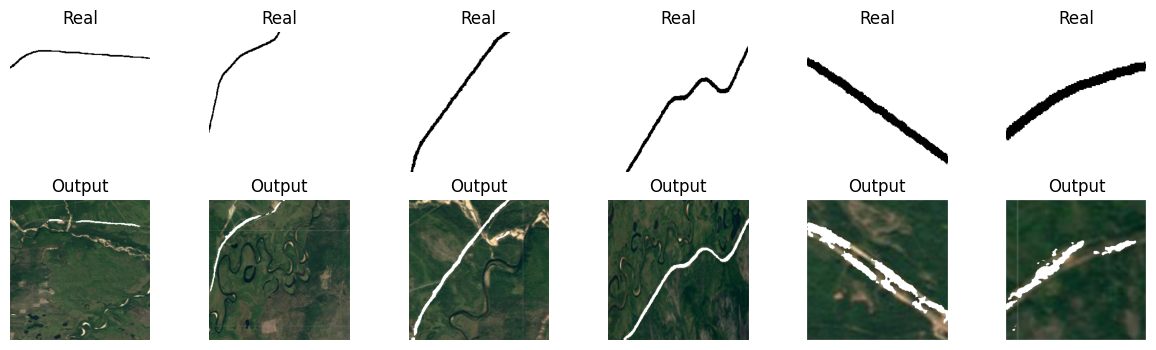

In [ ]:
print_image(model2, data_val)

In [ ]:
torch.cuda.empty_cache()
gc.collect()
del model